In [1]:
import os
import numpy as np
import pandas as pd
import re
import time
import helper
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score

import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from PIL import Image,ImageDraw,ImageFont


In [2]:
weight=models.ResNet18_Weights.IMAGENET1K_V1
model=models.resnet18(weights=weight)

weight1=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1
model1=models.efficientnet_v2_l(weights=weight1)

weight2=models.VGG16_Weights.IMAGENET1K_V1
model2=models.vgg16(weights=weight2)

weight3=models.AlexNet_Weights.IMAGENET1K_V1
model3=models.alexnet(weights=weight3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:07<00:00, 62.6MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 91.3MB/s]
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 60.6MB/s]


In [4]:
input_tensors=[]
images=[f for f in os.listdir('/content/input') if f.lower().endswith('jpg')]

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5))
    ])

ground_truth_labels=[]
for i in images:
  ground_truth_labels.append(i.split('1')[0].split('_')[0])
  image_path = os.path.join('/content/input', i)
  tensor_img=read_image(image_path)
  tensor_img = transforms.ToPILImage()(tensor_img)
  tensor_img = transform(tensor_img)
  input_tensors.append(tensor_img)


image_batch = torch.stack(input_tensors)

print(f"Loaded {len(input_tensors)} images, Batch shape: {image_batch.shape}")

Loaded 8 images, Batch shape: torch.Size([8, 3, 224, 224])


In [5]:
models_list= [model,model1,model2,model3]
weights=[weight,weight1,weight2,weight3]

predicted_labels=[]
confidence_score=[]
results= []

for model,weight in zip(models_list,weights):
  start_time = time.time()
  predictions = model(image_batch).softmax(dim=1)
  end_time = time.time()

  inference_time = end_time - start_time

  model_name = str(weight)
  model_name=re.search(r"(.*?)_", model_name).group(1)


  for i in range(predictions.shape[0]):
    class_id = predictions[i].argmax().item()
    score = predictions[i, class_id].item()
    category_name = weight.meta["categories"][class_id]
    predicted_labels.append(category_name)
    confidence_score.append(score)

  results.append({
    'model_name':model_name,
    'predicted_labels':predicted_labels,
    'confidence_score':confidence_score,
    'inference_time':inference_time
  })



In [6]:
final_df=pd.DataFrame(results)

In [10]:
accuracies = []
def calculate_accuracy_for_column(column_data, ground_truth):
  predicted_labels_subset = predicted_labels[:len(ground_truth_labels)]
  accuracy = accuracy_score(ground_truth_labels, predicted_labels_subset)
  return accuracy

accuracy_results = final_df['predicted_labels'].apply(lambda x: calculate_accuracy_for_column(x, ground_truth_labels))

In [11]:
final_df['Accuracy']=accuracy_results

In [12]:
final_df.to_excel('week2_exercise3_resutls.xlsx',index=False)

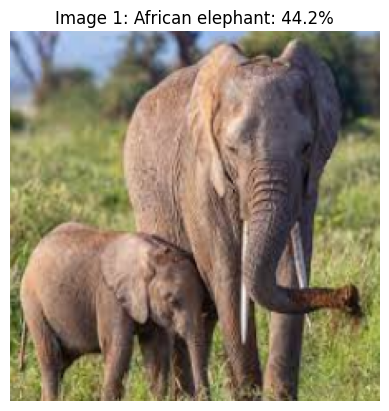

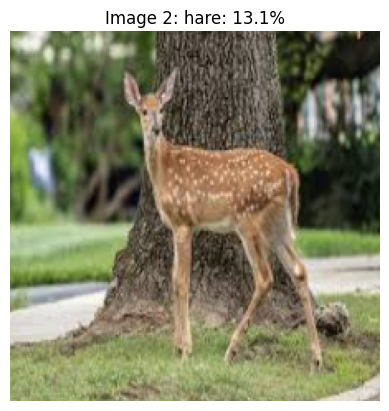

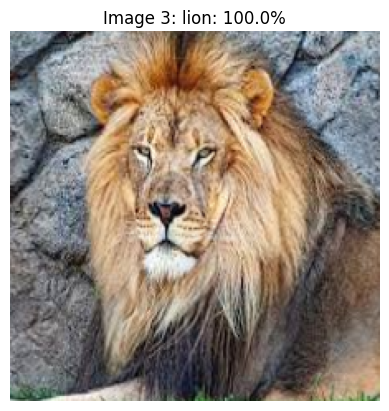

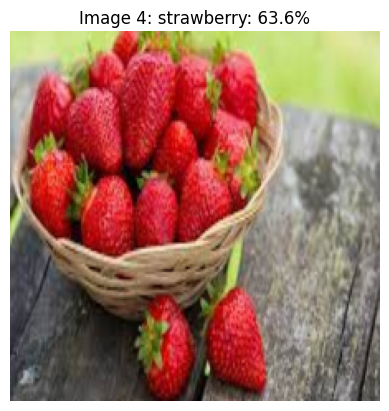

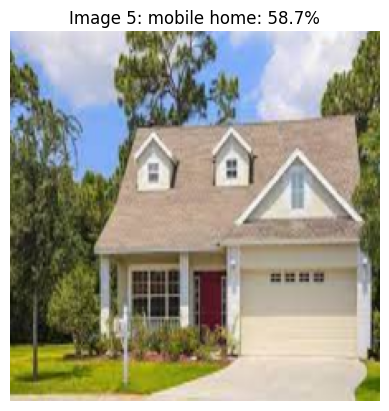

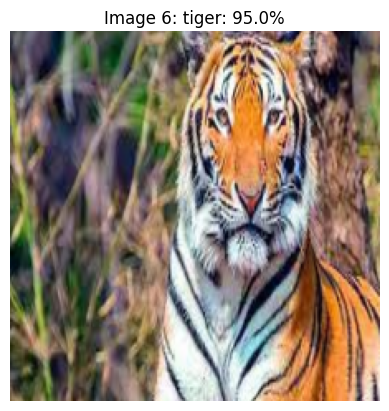

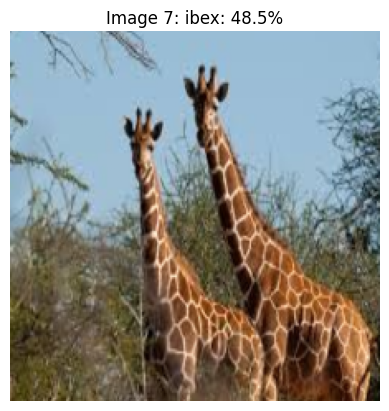

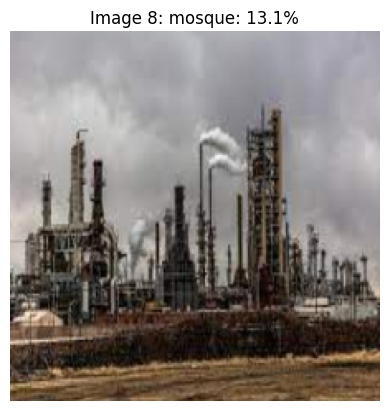

In [61]:

for i in range(predictions.shape[0]):
    class_id = predictions[i].argmax().item()
    score = predictions[i, class_id].item()
    category_name = weights.meta["categories"][class_id]

    image = image_batch[i]

    image = image.permute(1, 2, 0)
    image = image.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())

    plt.imshow(image)
    plt.title(f"Image {i + 1}: {category_name}: {100 * score:.1f}%")
    plt.axis('off')  # Hide axes
    plt.show()